In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os, sys
WORKING_DIR = os.path.dirname(os.path.abspath(''))
sys.path.insert(1, os.path.join(WORKING_DIR,'LensQuEst'))

#to get latex to work, shoulldn't be necessary for most ppl
os.environ['PATH'] = "%s:/usr/local/cuda-11.2/bin:/usr/local/bin:/usr/bin:/usr/local/sbin:/usr/sbin:/opt/anaconda/bin:/home/delon/texlive/bin/x86_64-linux:/home/delon/.local/bin:/home/delon/bin"%os.environ['PATH']

In [3]:
from universe import *
from halo_fit import *
from cmb import *
from flat_map import *
from weight import *
from pn_2d import *
import pickle
from tqdm import trange,tqdm 

from itertools import product


In [4]:
#######
DATA_FNAME = '/data/delon/LensQuEst/N0_Ni.pkl'
mean_field_file = 'mask_simple400x400_point_sources_bigger.pkl'
import warnings
warnings.filterwarnings("ignore")
#####

In [5]:
print("Map properties")

# number of pixels for the flat map
nX = 400 # 1200
nY = 400 #1200

# map dimensions in degrees
sizeX = 10.
sizeY = 10.

# basic map object
baseMap = FlatMap(nX=nX, nY=nY, sizeX=sizeX*np.pi/180., sizeY=sizeY*np.pi/180.)

# multipoles to include in the lensing reconstruction
lMin = 30.; lMax = 3.5e3

# ell bins for power spectra
nBins = 21  # number of bins
lRange = (1., 2.*lMax)  # range for power spectra

Map properties


In [6]:
print("CMB experiment properties")

# Adjust the lMin and lMax to the assumptions of the analysis
# CMB S3 specs
cmb = StageIVCMB(beam=1., noise=1., lMin=lMin, lMaxT=lMax, lMaxP=lMax, atm=False)

# Total power spectrum, for the lens reconstruction
# basiscally gets what we theoretically expect the
# power spectrum will look like
forCtotal = lambda l: cmb.flensedTT(l) + cmb.fdetectorNoise(l)

# reinterpolate: gain factor 10 in speed
L = np.logspace(np.log10(lMin/2.), np.log10(2.*lMax), 1001, 10.)
F = np.array(list(map(forCtotal, L)))
cmb.fCtotal = interp1d(L, F, kind='linear', bounds_error=False, fill_value=0.)

CMB experiment properties


In [7]:
print("CMB lensing power spectrum")
u = UnivPlanck15()
halofit = Halofit(u, save=False)
w_cmblens = WeightLensSingle(u, z_source=1100., name="cmblens")
p2d_cmblens = P2dAuto(u, halofit, w_cmblens, save=False)

CMB lensing power spectrum


In [8]:
print("Gets a theoretical prediction for the noise")
fNqCmb_fft = baseMap.forecastN0Kappa(cmb.funlensedTT, cmb.ftotal, lMin=lMin, lMax=lMax, test=False)
Ntheory = lambda l: fNqCmb_fft(l) #+ fNqCmbFG_fft(l)

Gets a theoretical prediction for the noise
computing the reconstruction noise


In [9]:
#https://stackoverflow.com/questions/12201577/how-can-i-convert-an-rgb-image-into-grayscale-in-python
def rgb2gray(rgb):
    return np.dot(rgb[...,:3], [0.2989, 0.5870, 0.1140])

In [10]:
from scipy.ndimage import gaussian_filter 
from scipy.fft import fft2

mask = rgb2gray(plt.imread('mask_simple%dx%d.png'%(nX, nY)))
apodized_mask = gaussian_filter(mask, 3)
point_sources = rgb2gray(plt.imread('point_sources_bigger.png'))
point_sources = gaussian_filter(point_sources, 1.5) 
apodized_mask += point_sources
nPos = np.where(apodized_mask>1)
apodized_mask[nPos] = 1
mask = 1-mask
apodized_mask = 1 - apodized_mask

for a in apodized_mask:
    for b in a:
        assert(b<=1 and b>=0)

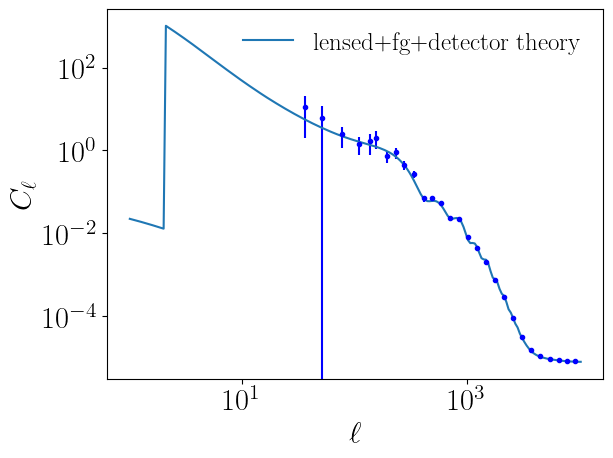

(array([1.10134950e+00, 1.32459194e+00, 1.59308540e+00, 1.91600222e+00,
        2.30437396e+00, 2.77146825e+00, 3.33324210e+00, 4.00888694e+00,
        4.82148431e+00, 5.79879436e+00, 6.97420418e+00, 8.38786839e+00,
        1.00880809e+01, 1.21329248e+01, 1.45922566e+01, 1.75500924e+01,
        2.11074786e+01, 2.53859434e+01, 3.05316487e+01, 3.60000000e+01,
        4.41635684e+01, 5.09116882e+01, 6.38819341e+01, 7.68562555e+01,
        9.24042521e+01, 1.09223860e+02, 1.35885626e+02, 1.54318492e+02,
        1.91270149e+02, 2.30849319e+02, 2.75913978e+02, 3.37767020e+02,
        4.09214632e+02, 4.87121784e+02, 5.84541819e+02, 7.05780752e+02,
        8.49567654e+02, 1.02071625e+03, 1.22784902e+03, 1.47725961e+03,
        1.77543811e+03, 2.13554713e+03, 2.56878450e+03, 3.08962009e+03,
        3.71631490e+03, 4.46999817e+03, 5.37515810e+03, 6.46451210e+03,
        7.62336414e+03, 9.02805575e+03]),
 array([0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00

In [11]:
cmb0Fourier = baseMap.genGRF(cmb.funlensedTT, test=False)
cmb0 = baseMap.inverseFourier(cmb0Fourier)

kCmbFourier = baseMap.genGRF(p2d_cmblens.fPinterp, test=False)
kCmb = baseMap.inverseFourier(kCmbFourier)

lensedCmb = baseMap.doLensing(cmb0, kappaFourier=kCmbFourier)
lensedCmbFourier = baseMap.fourier(lensedCmb)

fgFourier = baseMap.genGRF(cmb.fForeground, test=False)
lensedCmbFourier = lensedCmbFourier + fgFourier
lensedCmb = baseMap.inverseFourier(lensedCmbFourier)

noiseFourier = baseMap.genGRF(cmb.fdetectorNoise, test=False)
totalCmbFourier = lensedCmbFourier + noiseFourier
totalCmb = baseMap.inverseFourier(totalCmbFourier)

baseMap.powerSpectrum(totalCmbFourier,theory=[cmb.ftotal], 
                                      theory_l=['lensed+fg+detector'],
                                      plot=True, save=False)

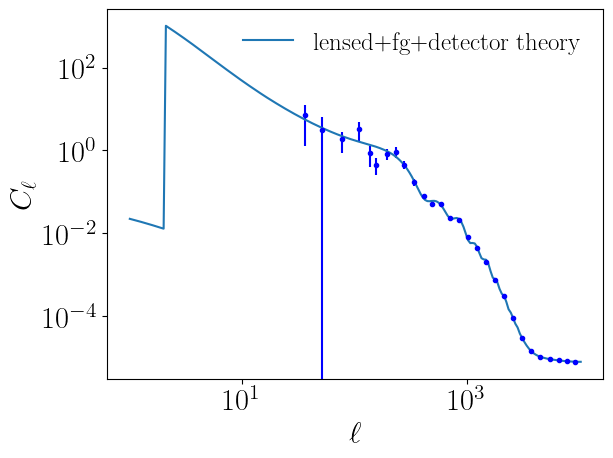

(array([1.10134950e+00, 1.32459194e+00, 1.59308540e+00, 1.91600222e+00,
        2.30437396e+00, 2.77146825e+00, 3.33324210e+00, 4.00888694e+00,
        4.82148431e+00, 5.79879436e+00, 6.97420418e+00, 8.38786839e+00,
        1.00880809e+01, 1.21329248e+01, 1.45922566e+01, 1.75500924e+01,
        2.11074786e+01, 2.53859434e+01, 3.05316487e+01, 3.60000000e+01,
        4.41635684e+01, 5.09116882e+01, 6.38819341e+01, 7.68562555e+01,
        9.24042521e+01, 1.09223860e+02, 1.35885626e+02, 1.54318492e+02,
        1.91270149e+02, 2.30849319e+02, 2.75913978e+02, 3.37767020e+02,
        4.09214632e+02, 4.87121784e+02, 5.84541819e+02, 7.05780752e+02,
        8.49567654e+02, 1.02071625e+03, 1.22784902e+03, 1.47725961e+03,
        1.77543811e+03, 2.13554713e+03, 2.56878450e+03, 3.08962009e+03,
        3.71631490e+03, 4.46999817e+03, 5.37515810e+03, 6.46451210e+03,
        7.62336414e+03, 9.02805575e+03]),
 array([0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00

In [12]:
totalCmbFourier = baseMap.genGRF(cmb.ftotal)
baseMap.powerSpectrum(totalCmbFourier,theory=[cmb.ftotal], 
                                      theory_l=['lensed+fg+detector'],
                                      plot=True, save=False)

In [13]:
data = {}

In [14]:
f = open(DATA_FNAME, 'rb') 
data = pickle.load(f) 
f.close()

for key in data:
    print(key, np.shape(data[key]))

In [27]:
N_RUNS = 2
poss = list(product([True, False],[True, False], range(N_RUNS)))
fsky = np.sum(apodized_mask)/(nX*nY)
c1 = fsky
c2 = fsky**2

data = {}


for MASKED, LENSED, run_n in tqdm(poss):
    post_fix = '%d_%d'%(MASKED,LENSED)

    mean_field = pickle.load(open(mean_field_file, 'rb'))
    if(not MASKED):
        mean_field = np.zeros_like(mean_field)

    totalCmbFourier, totalCmb = 0, 0
    if(not LENSED):
        totalCmbFourier = baseMap.genGRF(cmb.ftotal)
        totalCmb = baseMap.inverseFourier(totalCmbFourier)
    elif(LENSED):
        cmb0Fourier = baseMap.genGRF(cmb.funlensedTT, test=False)
        cmb0 = baseMap.inverseFourier(cmb0Fourier)

        kCmbFourier = baseMap.genGRF(p2d_cmblens.fPinterp, test=False)
        kCmb = baseMap.inverseFourier(kCmbFourier)

        lensedCmb = baseMap.doLensing(cmb0, kappaFourier=kCmbFourier)
        lensedCmbFourier = baseMap.fourier(lensedCmb)

        fgFourier = baseMap.genGRF(cmb.fForeground, test=False)
        lensedCmbFourier = lensedCmbFourier + fgFourier
        lensedCmb = baseMap.inverseFourier(lensedCmbFourier)

        noiseFourier = baseMap.genGRF(cmb.fdetectorNoise, test=False)
        totalCmbFourier = lensedCmbFourier + noiseFourier
        totalCmb = baseMap.inverseFourier(totalCmbFourier)

    if(MASKED):
        totalCmb = apodized_mask*totalCmb
        totalCmbFourier = baseMap.fourier(totalCmb)

    c_Data = {}
    
    #kappa
    c_Data['k'+post_fix] = baseMap.computeQuadEstKappaNorm(cmb.funlensedTT, 
                                                           cmb.fCtotal, 
                                                           lMin=lMin, lMax=lMax,
                                                           dataFourier=totalCmbFourier)
    if(MASKED):
        c_Data['k'+post_fix] -= mean_field

    #Nhat
    c_Data['sqrtNhat'+post_fix] = baseMap.computeQuadEstKappaAutoCorrectionMap(cmb.funlensedTT, 
                                                                               cmb.fCtotal, 
                                                                               lMin=lMin, lMax=lMax, 
                                                                               dataFourier=totalCmbFourier)

    #kappaR
    totalCmbFourierRandomized = baseMap.randomizePhases(totalCmbFourier)
    totalCmbRandomized = baseMap.inverseFourier(totalCmb)
    c_Data['kR'+post_fix] = baseMap.computeQuadEstKappaNorm(cmb.funlensedTT, 
                                                            cmb.fCtotal, 
                                                            lMin=lMin, lMax=lMax,
                                                            dataFourier=totalCmbFourierRandomized)

    c_Data['Nhat'+post_fix] = [0,0,0]
    c_Data['kRkR'+post_fix] = [0,0,0]
    c_Data['kk'+post_fix]   = [0,0,0]
    
    c_Data['kk'+post_fix][0],   c_Data['kk'+post_fix][1],   c_Data['kk'+post_fix][2]   = baseMap.powerSpectrum(dataFourier=c_Data['k'+post_fix])
    c_Data['Nhat'+post_fix][0], c_Data['Nhat'+post_fix][1], c_Data['Nhat'+post_fix][2] = baseMap.powerSpectrum(dataFourier=c_Data['sqrtNhat'+post_fix])
    c_Data['kRkR'+post_fix][0], c_Data['kRkR'+post_fix][1], c_Data['kRkR'+post_fix][2] = baseMap.powerSpectrum(dataFourier=c_Data['kR'+post_fix])

    if(MASKED):
        #fsky corrections
        c_Data['kk'+post_fix][1] /= c1
        c_Data['kk'+post_fix][2] /= c1
        
        c_Data['Nhat'+post_fix][1] /= c2
        c_Data['Nhat'+post_fix][2] /= c2

        c_Data['kRkR'+post_fix][1] /= c2
        c_Data['kRkR'+post_fix][2] /= c2

    for key in c_Data:
        if(key not in data.keys()):
            data[key] = np.array([c_Data[key]])
        else:
            data[key] = np.vstack((np.array([c_Data[key]]), data[key]))  
            
    f = open(DATA_FNAME, 'wb') 
    pickle.dump(data, f)
    f.close()

100%|██████████| 8/8 [05:34<00:00, 41.77s/it]


plotting data
2 (2, 3, 50)
2 (2, 3, 50)


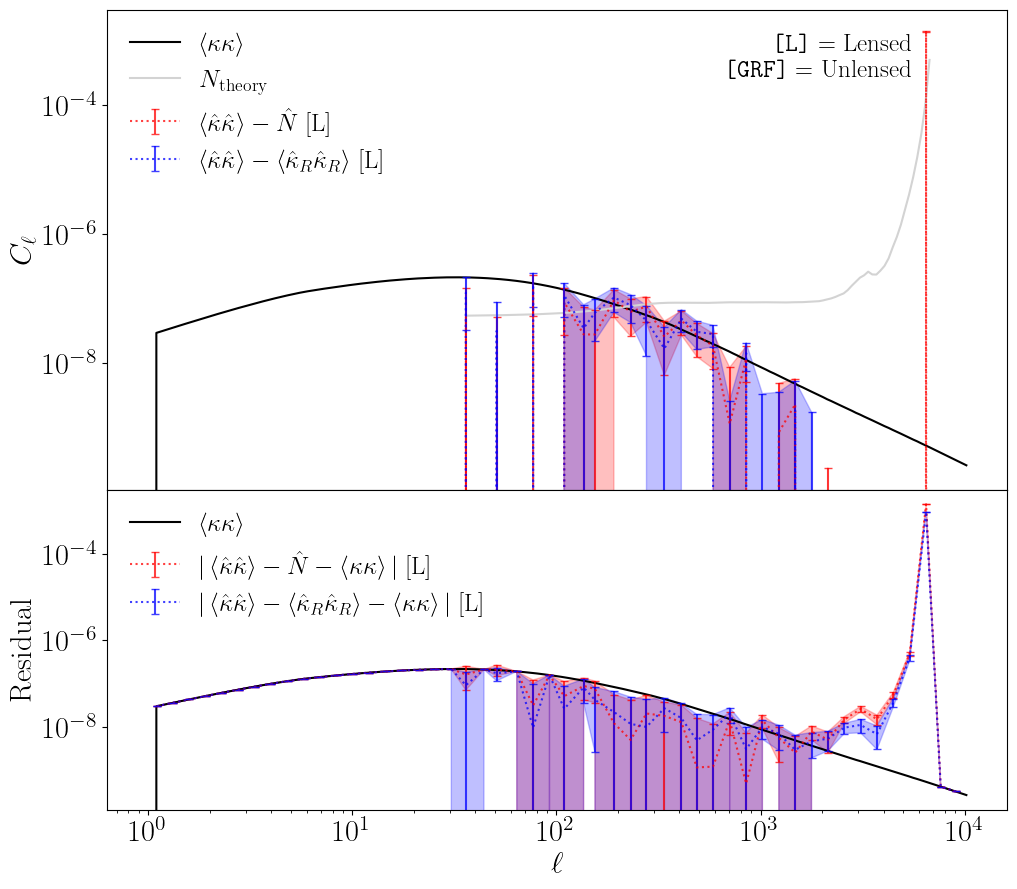

In [28]:
fig1 = plt.figure(figsize =(12, 8))

axs=[fig1.add_axes((0.2,0.4,.75,.6)), fig1.add_axes((0.2,0.0,.75,.4))]

# fig.subplots_adjust(wspace=0, hspace=0)
ell = baseMap.l.flatten()

theory=[p2d_cmblens.fPinterp, Ntheory]
theory_l=[r'$\big<\kappa\kappa\big>$', r'$N_{\rm theory}$']
theory_s=['black', 'lightgrey']
for f,l,sty in zip(theory, theory_l, theory_s):
    L = np.logspace(np.log10(1.), np.log10(np.max(ell)), 201, 10.)
    ClExpected = np.array(list(map(f, L)))
    for ax_idx in range(len(axs)):
        ax = axs[ax_idx]
        if(ax_idx==1 and sty=='lightgrey'):
            continue
        ax.plot(L, ClExpected, sty, label=l)


c_keys = [
    'Nhat1_1',
    'kRkR1_1',
]

col = dict(zip(c_keys, [
    'r',
    'b',
]))

labels = dict(zip(c_keys, [
    r'$\left<\hat\kappa\hat\kappa\right> - \hat N$ [L]',
    r'$\left<\hat\kappa\hat\kappa\right> - \left<\hat\kappa_R\hat\kappa_R\right>$ [L]',
]))

aux_labels = dict(zip(c_keys, [
    r'$|\left<\hat\kappa\hat\kappa\right> - \hat N - \left<\kappa\kappa\right>|$ [L]',
    r'$|\left<\hat\kappa\hat\kappa\right> - \left<\hat\kappa_R\hat\kappa_R\right> - \left<\kappa\kappa\right>|$ [L]',
]))
print('plotting data')

idxs = dict(zip(c_keys,
               [
                   [0],
                   [0],
               ]))

for key in c_keys:
    tmp_postfix = (key.split('_'))
    c_postfix = tmp_postfix[0][-1]+'_'+tmp_postfix[1]
    
    Cls_tmp = np.transpose(np.copy(data['kk'+c_postfix]), axes=[1,2,0])
    Cls_tmp[1] -= np.transpose(data[key], axes=[1,2,0])[1]
    Cls_tmp = np.transpose(Cls_tmp, axes=[2,0,1])
    
    lCen, Cl, sCl = combine_Cl(Cls_tmp)

    Ipos = np.where(Cl>=1e-30)

    
    ax = axs[0]

    ax.errorbar(lCen, (Cl), 
                yerr=sCl, c=col[key], 
                alpha=.75, fmt=':', 
                capsize=3, label=labels[key], capthick=1)

    tmp_data = {
       'x': lCen,
       'y1': [y - e for y, e in zip((Cl), sCl)],
       'y2': [y + e for y, e in zip((Cl), sCl)]}
    ax.fill_between(**tmp_data, color=col[key], alpha=.25)
    
    
    Cl_res = Cl - np.array(list(map(p2d_cmblens.fPinterp, lCen)))
    ax = axs[1]

    ax.errorbar(lCen, np.abs(Cl_res), 
                yerr=sCl, c=col[key], 
                alpha=.75, fmt=':', 
                capsize=3, label=aux_labels[key], capthick=1)

    tmp_data = {
       'x': lCen,
       'y1': [y - e for y, e in zip(np.abs(Cl_res), sCl)],
       'y2': [y + e for y, e in zip(np.abs(Cl_res), sCl)]}
    ax.fill_between(**tmp_data, color=col[key], alpha=.25)
    
    ax.set_ylabel(r'Residual')

    
axs[1].axhline(0, linewidth=1, linestyle="--", color="black")
for ax_idx in range(len(axs)):
    ax = axs[ax_idx]
    l=ax.legend(frameon=False, loc='upper left')
    ax.set_xscale('log')
    ax.set_xlabel(r'$\ell$')
    ax.set_yscale('log')
    ax.set_xlim(0)
    if(ax_idx==1):
        continue

    s = r'\texttt{[L]} = Lensed'
    s += '\n'
    s += r'\texttt{[GRF]} = Unlensed'
    ax.text(.90, .95,
       s=s,
       transform=ax.transAxes,
       horizontalalignment='right',
       verticalalignment='top',
      fontsize=18)
    ax.set_ylabel(r'$C_\ell$')
plt.savefig(
'figures/Cl_lensed.pdf',
    bbox_inches='tight'
)